# Задание 3.

https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis
c этим датасетом будем работать на уроке.

ДЗ -

1. Заполнить пропуски наиболее релеватным путем, аргументировать это.

2. Таргетом оставляем признак - болен аппендицитом или нет.

3. Построить три различные типа классификаторов, обязательно одну из них Keras или PyTorch. Построить графики функции потерь на трейне и тесте.

4. Визуализировать важность признаков с точки зрения модели - чемпиона.

5. Составить грамотный обобщающий вывод.

Сдавать как обычно - Гитхаб или Гугл Колаб.

# Постановка задачи

Определить класс диагностического решения. Таргет - Diagnosis (бинарный)

# Загрузка данных

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# data (as pandas dataframes)
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

# metadata
print(regensburg_pediatric_appendicitis.metadata)

# variable information
print(regensburg_pediatric_appendicitis.variables)

{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

## Описание датасета

Этот набор данных был получен в ходе ретроспективного исследования группы педиатрических пациентов, госпитализированных с болью в животе в детскую больницу Святой Хедвиги в Регенсбурге, Германия.

Большинству пациентов было сделано несколько ультразвуковых изображений брюшной полости в В-режиме, при этом количество просмотров варьировало от 1 до 15. На изображениях выдны различные области, представляющие интерес, такие как правый нижний квадрант живота, аппендикс, кишечник, лимфатические узлы и репродуктивные органы.

Наряду с несколькими снимками УЗИ для каждого субъекта, набор данных включает в себя информацию, охватывающую лабораторные тесты, результаты физикального осмотра, клинические оценки, такие как Альварадо и детский аппендицит, а также результаты ультразвукового исследования, полученные экспертами.

Наконец, испытуемые были помечены по трем целевым переменным: диагноз (аппендицит или отсутствие аппендицита), лечение (хирургическое или консервативное) и тяжесть (осложненный или неосложненный аппендицит или отсутствие аппендицита). Исследование было одобрено Комитетом по этике Университета Регенсбурга (No 18-1063-101, 18-1063_1-101 и 18-1063_2-101) и выполнено в соответствии с действующими рекомендациями и правилами.

# Импорт библиотек

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
!pip install fancyimpute -q
!pip install catboost -q
!pip install eli5 -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, label_binarize


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# EDA

In [ ]:
# Объединение датасета
df = pd.concat([X, y], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

17 числовых признаков, 39 категориальных

У таргета отсутствует одно значение. Удалим эту строку.

In [ ]:
df = df.dropna(subset = ['Diagnosis'])

In [ ]:
df.isna().sum()

Age                                   0
BMI                                  26
Sex                                   1
Height                               25
Weight                                2
Length_of_Stay                        3
Alvarado_Score                       50
Paedriatic_Appendicitis_Score        50
Appendix_on_US                        3
Appendix_Diameter                   282
Migratory_Pain                        7
Lower_Right_Abd_Pain                  6
Contralateral_Rebound_Tenderness     13
Coughing_Pain                        14
Nausea                                6
Loss_of_Appetite                      8
Body_Temperature                      5
WBC_Count                             4
Neutrophil_Percentage               101
Segmented_Neutrophils               726
Neutrophilia                         48
RBC_Count                            16
Hemoglobin                           16
RDW                                  24
Thrombocyte_Count                    16


## формирование списка для удаления неинформативных колонок, обработка пропусков

Посмотрим признаки с пропусками в процентном соотношении

In [ ]:
null = df.isna().sum()/len(df) * 100
null = pd.DataFrame({'feature':null.index, 'null_percentage':null}).sort_values(by='null_percentage', ascending=False).reset_index(drop=True)

In [ ]:
null

,feature,null_percentage
0,Abscess_Location,98.333333
1,Gynecological_Findings,96.666667
2,Conglomerate_of_Bowel_Loops,94.487179
3,Segmented_Neutrophils,93.076923
4,Ileus,92.307692
5,Perfusion,91.923077
6,Enteritis,91.538462
7,Appendicolith,91.153846
8,Coprostasis,90.897436
9,Perforation,89.615385


Подробно будем рассматривать признаки с пропусками > 10 %

In [ ]:
# список колонок для удаления
for_drop = []

Признак Abscess_Location (локация абсцесса) заполнен всего 13-ю строками со значениями (Douglas, retrovesikal, rechter Unterbauch, perityphlitisch, an den M. psoas rechts). Признак неинформативен.

In [ ]:
for_drop.append('Abscess_Location')

Признак Gynecological Findings (уточнения по геникологии) заполнен 26-ю строками. У половины из списка найдены кисты яичников. Слишком мало для информативности.

In [ ]:
for_drop.append('Gynecological_Findings')

Признак Conglomerate_of_Bowel_Loops (конгломерат кишечника) заполнен на 43 строчках. Значения yes, no. Неинформативен.

In [ ]:
for_drop.append('Conglomerate_of_Bowel_Loops')

Признак Segmented_Neutrophils (Сегментированные нейтрофилы)	54 строки заполнено. Численные значения. Указывают на восполительный процесс в организме. Нет гарантии, что этот процесс - аппендицит.

In [ ]:
for_drop.append('Segmented_Neutrophils')

Признак Ileus (Кишечная непроходимость) 60 строк заполнено. Значения yes, no. Кишечная непроходимость прямо не указывает на аппендицит.

In [ ]:
for_drop.append('Ileus')

Признак Perfusion (Перфузия) -  метод подведения и пропускания крови, кровезамещающих растворов и биологически активных веществ через сосудистую систему органов и тканей организма. 63 значения. Хоть этот метод проводится на аппендиксе и у 61 из 63 пациентов диагностирован аппендицит, все равно 63 значения из 782 это очень мало. Замену на моду считаю неправильной.

In [ ]:
for_drop.append('Perfusion')

Признак Enteritis (воспаление в области тонкого кишечника). Аппендикс является частью слепой кишки, не тонкого кишечника.

In [ ]:
for_drop.append('Enteritis')

Признак Appendicolith (Аппендиколит) это образование, которое формируется из-за кальцифицированных отложений в аппендиксе, состоящих из плотных каловых масс и иногда минеральных отложений 69 значений. Признак является прямым предшественником аппендицита.

In [ ]:
df_colith = df[df['Appendicolith'] == 'yes']

In [ ]:
df_colith['Diagnosis']

39     appendicitis
74     appendicitis
347    appendicitis
488    appendicitis
492    appendicitis
513    appendicitis
521    appendicitis
533    appendicitis
534    appendicitis
538    appendicitis
548    appendicitis
553    appendicitis
554    appendicitis
563    appendicitis
568    appendicitis
574    appendicitis
586    appendicitis
589    appendicitis
590    appendicitis
593    appendicitis
599    appendicitis
607    appendicitis
612    appendicitis
622    appendicitis
651    appendicitis
670    appendicitis
685    appendicitis
697    appendicitis
720    appendicitis
722    appendicitis
755    appendicitis
759    appendicitis
763    appendicitis
Name: Diagnosis, dtype: object

Считаю, что если у пациента диагноституется Аппендиколит, то этот факт обязательно указывается в истории болезни. Значит, пропуски заполняем значением 'no'.

In [ ]:
df['Appendicolith'].fillna('no', inplace=True)

In [ ]:
df['Appendicolith'].value_counts()

Appendicolith
no           744
yes           33
suspected      3
Name: count, dtype: int64

Признак Coprostasis (Скопление каловых масс в толстой кишке кишечник).

In [ ]:
df_copro = df[df['Coprostasis'] == 'yes']

In [ ]:
df_copro['Diagnosis']

22     no appendicitis
29        appendicitis
40        appendicitis
46     no appendicitis
66     no appendicitis
67     no appendicitis
101    no appendicitis
104       appendicitis
141    no appendicitis
183       appendicitis
214    no appendicitis
224    no appendicitis
253       appendicitis
256       appendicitis
260    no appendicitis
281    no appendicitis
283       appendicitis
286    no appendicitis
288    no appendicitis
311    no appendicitis
317    no appendicitis
344    no appendicitis
354    no appendicitis
356    no appendicitis
410    no appendicitis
434       appendicitis
445    no appendicitis
449    no appendicitis
463    no appendicitis
465    no appendicitis
470    no appendicitis
475       appendicitis
485       appendicitis
523       appendicitis
547       appendicitis
560       appendicitis
571       appendicitis
594       appendicitis
633       appendicitis
637       appendicitis
650       appendicitis
651       appendicitis
672       appendicitis
694       a

Считаю, что признак неинформативен, прямой зависимости с таргетом нет.

In [ ]:
for_drop.append('Coprostasis')

Признак Perforation (Признаки перфорации аппендикса при УЗИ)

In [ ]:
df_per = df[df['Perforation'] == 'yes']
df_per['Diagnosis']

500    appendicitis
522    appendicitis
529    appendicitis
536    appendicitis
543    appendicitis
547    appendicitis
550    appendicitis
553    appendicitis
560    appendicitis
561    appendicitis
562    appendicitis
563    appendicitis
565    appendicitis
569    appendicitis
582    appendicitis
607    appendicitis
615    appendicitis
630    appendicitis
640    appendicitis
647    appendicitis
649    appendicitis
650    appendicitis
651    appendicitis
655    appendicitis
667    appendicitis
670    appendicitis
743    appendicitis
744    appendicitis
753    appendicitis
Name: Diagnosis, dtype: object

In [ ]:
df_per = df[df['Perforation'] == 'no']
df_per['Diagnosis']

0         appendicitis
15     no appendicitis
47        appendicitis
50        appendicitis
51     no appendicitis
67     no appendicitis
121       appendicitis
127       appendicitis
129       appendicitis
138       appendicitis
150    no appendicitis
164       appendicitis
245       appendicitis
334       appendicitis
398       appendicitis
492       appendicitis
513       appendicitis
555       appendicitis
576       appendicitis
618       appendicitis
623       appendicitis
625       appendicitis
733       appendicitis
734       appendicitis
735       appendicitis
736       appendicitis
737       appendicitis
738       appendicitis
739       appendicitis
745       appendicitis
746       appendicitis
747       appendicitis
749       appendicitis
768       appendicitis
Name: Diagnosis, dtype: object

In [ ]:
df.groupby('Perforation')['Diagnosis'].value_counts()

Perforation   Diagnosis      
no            appendicitis       30
              no appendicitis     4
not excluded  appendicitis       15
suspected     appendicitis        2
              no appendicitis     1
yes           appendicitis       29
Name: count, dtype: int64

Перфорация аппендикса прямое следствие аппендицита. Удалять колонку нельзя. Практически все заполненные значения признака Перфорации относятся к диагнозу аппендицит. Пропуски заполняем значением suspected, у которого более сбалансированы варианты диагноза.

In [ ]:
df['Perforation'].fillna('suspected', inplace=True)

In [ ]:
df['Perforation'].value_counts()

Perforation
suspected       702
no               34
yes              29
not excluded     15
Name: count, dtype: int64

Признак Appendicular_Abscess (Аппендикулярный абсцесс) - осложнение острого аппендицита.

In [ ]:
df_app = df[df['Appendicular_Abscess'] == 'no']
df_app['Diagnosis']

0         appendicitis
15     no appendicitis
37     no appendicitis
41        appendicitis
78        appendicitis
            ...       
757       appendicitis
766       appendicitis
768       appendicitis
772       appendicitis
781       appendicitis
Name: Diagnosis, Length: 65, dtype: object

In [ ]:
df.groupby('Appendicular_Abscess')['Diagnosis'].value_counts()

Appendicular_Abscess  Diagnosis      
no                    appendicitis       56
                      no appendicitis     9
suspected             appendicitis        1
yes                   appendicitis       19
Name: count, dtype: int64

Признак Appendicular_Abscess не следует удалять, так как он является следствием аппендицита. Заменим пропуски значением 'not excluded' (не исключено), которое не нарушит баланс признака и сохранит связь с таргетом.


In [ ]:
df['Appendicular_Abscess'].fillna('not excluded', inplace=True)
df['Appendicular_Abscess'].value_counts()

Appendicular_Abscess
not excluded    695
no               65
yes              19
suspected         1
Name: count, dtype: int64

Признак Bowel_Wall_Thickening (Утолщение внутренней стенки кишечника). 99 значений заполнено. Удаляем.

In [ ]:
for_drop.append('Bowel_Wall_Thickening')

Признак Lymph_Nodes_Location (Расположение лимфатических узлов)

In [ ]:
df.groupby('Lymph_Nodes_Location')['Diagnosis'].value_counts()

Lymph_Nodes_Location            Diagnosis      
Ileozökal                       appendicitis        1
Lymphadenopathie                appendicitis        1
MB                              no appendicitis     2
Mesenterial, links inguinal     appendicitis        1
Ovarialzysten                   appendicitis        1
UB                              no appendicitis     1
ileocoecal                      appendicitis        2
                                no appendicitis     1
ileocoekal                      appendicitis        1
ileocöcal                       appendicitis        2
inguinal                        appendicitis        1
lokal um die Appendix           appendicitis        1
mesenterial                     no appendicitis    29
                                appendicitis        8
mesenterial, re UB              appendicitis        1
multiple Lokalisationen         appendicitis        1
periappendikulär                appendicitis        1
periumbilikal                   no

По распределению диагноза по группам локации лимфоузлов видно, что в большинстве случаев пациенты с аппендицитом имеют увеличенные узлы "rechter Unterbauch", а без аппендицита - 'mesenterial'. Заполним пропуски таким образом.

In [ ]:
df.loc[(df['Lymph_Nodes_Location'].isna()) & (df['Diagnosis'] == 'appendicitis'), 'Lymph_Nodes_Location'] = 'rechter Unterbauch'
df.loc[(df['Lymph_Nodes_Location'].isna()) & (df['Diagnosis'] == 'no appendicitis'), 'Lymph_Nodes_Location'] = 'mesenterial'
df['Lymph_Nodes_Location'].value_counts()

Lymph_Nodes_Location
rechter Unterbauch                424
mesenterial                       292
re UB                              22
reUB                               12
re MB                               3
ileocoecal                          3
re UB                               2
rechter Unter- und Mittelbauch      2
ileocöcal                           2
MB                                  2
inguinal                            1
lokal um die Appendix               1
multiple Lokalisationen             1
Mesenterial, links inguinal         1
Lymphadenopathie                    1
periappendikulär                    1
Ileozökal                           1
periumbilikal                       1
re UB, re MB                        1
UB                                  1
re UB, ileocoecal                   1
re UB                               1
re UB, periumbilikal                1
mesenterial, re UB                  1
ileocoekal                          1
Ovarialzysten                

Признак Target_Sign (Аксиальное изображение аппендикса с заполненным жидкостью центром, окруженным эхогенной и подслизистой оболочкой и гипоэхогенной мускулатурой). 138 значений заполнено.

In [ ]:
df.groupby('Target_Sign')['Diagnosis'].value_counts()

Target_Sign  Diagnosis      
no           no appendicitis    26
             appendicitis       25
yes          appendicitis       82
             no appendicitis     5
Name: count, dtype: int64

Заменим пропуски Target_Sign в зависимости от Diagnosis: appendicitis - yes, no appendicitis - not excluded.

In [ ]:
df.loc[(df['Target_Sign'].isna()) & (df['Diagnosis'] == 'appendicitis'), 'Target_Sign'] = 'yes'
df.loc[(df['Target_Sign'].isna()) & (df['Diagnosis'] == 'no appendicitis'), 'Target_Sign'] = 'not excluded'
df['Target_Sign'].value_counts()

Target_Sign
yes             443
not excluded    286
no               51
Name: count, dtype: int64

Признак Meteorism.

In [ ]:
df.groupby('Meteorism')['Diagnosis'].value_counts()

Meteorism  Diagnosis      
no         appendicitis       11
yes        no appendicitis    70
           appendicitis       59
Name: count, dtype: int64

Признак удаляем.

In [ ]:
for_drop.append('Meteorism')

Признак Pathological_Lymph_Nodes (Увеличенные и воспаленные внутрибрюшные лимфатические узлы)

In [ ]:
df.groupby('Pathological_Lymph_Nodes')['Diagnosis'].value_counts()

Pathological_Lymph_Nodes  Diagnosis      
no                        appendicitis       29
                          no appendicitis    20
yes                       appendicitis       82
                          no appendicitis    72
Name: count, dtype: int64

Неинформативный признак. Удаляем.

In [ ]:
for_drop.append('Pathological_Lymph_Nodes')

Признак Appendix_Wall_Layers (Распределение и характеристики слоев аппендикса, например, неравномерность при нарастающем воспалении)

In [ ]:
df.groupby('Appendix_Wall_Layers')['Diagnosis'].value_counts()

Appendix_Wall_Layers  Diagnosis      
intact                appendicitis       102
                      no appendicitis     30
partially raised      appendicitis         9
raised                appendicitis        73
                      no appendicitis      3
upset                 appendicitis         1
Name: count, dtype: int64

Заменим пропуски на признак intact (неповрежденный). Распределение диагноза по этому признаку ~ 1/3

In [ ]:
df['Appendix_Wall_Layers'].fillna('intact', inplace=True)
df['Appendix_Wall_Layers'].value_counts()

Appendix_Wall_Layers
intact              694
raised               76
partially raised      9
upset                 1
Name: count, dtype: int64

Признак Surrounding_Tissue_Reaction (Признаки воспаления в тканях (в т.ч. в сальнике/жировой ткани), окружающих аппендикс)

In [ ]:
df.groupby('Surrounding_Tissue_Reaction')['Diagnosis'].value_counts()

Surrounding_Tissue_Reaction  Diagnosis      
no                           appendicitis        28
                             no appendicitis     16
yes                          appendicitis       196
                             no appendicitis     12
Name: count, dtype: int64

Чтобы исключить ошибку второго рода (пропустить аппендицит там, где он есть) заменим пропуски на yes.

In [ ]:
df['Surrounding_Tissue_Reaction'].fillna('yes', inplace=True)
df['Surrounding_Tissue_Reaction'].value_counts()

Surrounding_Tissue_Reaction
yes    736
no      44
Name: count, dtype: int64

Признак Appendix_Diameter (Максимальный наружный диаметр аппендикса)

In [ ]:
df.groupby('Appendix_Diameter')['Diagnosis'].value_counts()

Appendix_Diameter  Diagnosis      
2.7                no appendicitis    1
2.9                no appendicitis    1
3.0                no appendicitis    2
3.2                no appendicitis    1
3.5                no appendicitis    5
                                     ..
13.0               appendicitis       8
13.2               appendicitis       1
14.0               appendicitis       5
15.0               appendicitis       4
17.0               appendicitis       1
Name: count, Length: 95, dtype: int64

Порог 6 мм. Заменим медианой.

In [ ]:
median_value = df['Appendix_Diameter'].median()
df['Appendix_Diameter'].fillna(median_value, inplace=True)
df['Appendix_Diameter'].value_counts()

Appendix_Diameter
7.5     292
8.0      47
9.0      46
7.0      43
6.0      42
       ... 
9.6       1
5.7       1
8.4       1
9.3       1
10.9      1
Name: count, Length: 78, dtype: int64

Признак RBC_in_Urine (Количество эритроцитов в единице объема мочи)

In [ ]:
df.groupby('RBC_in_Urine')['Diagnosis'].value_counts()

RBC_in_Urine  Diagnosis      
+             appendicitis        50
              no appendicitis     38
++            appendicitis         9
              no appendicitis      7
+++           appendicitis        20
              no appendicitis     10
no            appendicitis       238
              no appendicitis    204
Name: count, dtype: int64

Заменим пропуски на значение "no"

In [ ]:
df['RBC_in_Urine'].fillna('no', inplace=True)
df['RBC_in_Urine'].value_counts()

RBC_in_Urine
no     646
+       88
+++     30
++      16
Name: count, dtype: int64

Признак Ketones_in_Urine (Кетоны в моче)

In [ ]:
df.groupby('Ketones_in_Urine')['Diagnosis'].value_counts()

Ketones_in_Urine  Diagnosis      
+                 appendicitis        50
                  no appendicitis     27
++                appendicitis        29
                  no appendicitis     20
+++               appendicitis        86
                  no appendicitis     38
no                no appendicitis    179
                  appendicitis       153
Name: count, dtype: int64

Заменим пропуски на значение "no"

In [ ]:
df['Ketones_in_Urine'].fillna('no', inplace=True)
df['Ketones_in_Urine'].value_counts()

Ketones_in_Urine
no     530
+++    124
+       77
++      49
Name: count, dtype: int64

Признак WBC_in_Urine (Лейкоциты в моче)

In [ ]:
df.groupby('WBC_in_Urine')['Diagnosis'].value_counts()

WBC_in_Urine  Diagnosis      
+             appendicitis        30
              no appendicitis     21
++            appendicitis        11
              no appendicitis      8
+++           appendicitis         8
              no appendicitis      4
no            appendicitis       270
              no appendicitis    231
Name: count, dtype: int64

Заменим пропуски на значение "no"

In [ ]:
df['WBC_in_Urine'].fillna('no', inplace=True)
df['WBC_in_Urine'].value_counts()

WBC_in_Urine
no     698
+       51
++      19
+++     12
Name: count, dtype: int64

Признак Ipsilateral_Rebound_Tenderness (Состояние, при котором ощущается боль ипсилатеральной стороны при снятии давления над животом)

In [ ]:
df.groupby('Ipsilateral_Rebound_Tenderness')['Diagnosis'].value_counts()

Ipsilateral_Rebound_Tenderness  Diagnosis      
no                              no appendicitis    304
                                appendicitis       277
yes                             appendicitis        28
                                no appendicitis     10
Name: count, dtype: int64

Заменим пропуски на "не определено". Это сохранит важный диагностический признак и не собьёт баланс класса.

In [ ]:
df['Ipsilateral_Rebound_Tenderness'].fillna('not excluded', inplace=True)
df['Ipsilateral_Rebound_Tenderness'].value_counts()

Ipsilateral_Rebound_Tenderness
no              581
not excluded    161
yes              38
Name: count, dtype: int64

Признак Neutrophil_Percentage (Процент нейтрофилов)

In [ ]:
df.groupby('Neutrophil_Percentage')['Diagnosis'].value_counts()

Neutrophil_Percentage  Diagnosis      
27.2                   no appendicitis    1
29.5                   appendicitis       1
29.7                   appendicitis       1
32.2                   no appendicitis    1
35.1                   no appendicitis    1
                                         ..
93.8                   no appendicitis    1
93.9                   appendicitis       1
94.1                   appendicitis       1
94.2                   appendicitis       1
97.7                   appendicitis       1
Name: count, Length: 456, dtype: int64

Заменяет пропуски медианой.

In [ ]:
median_value = df['Neutrophil_Percentage'].median()
df['Neutrophil_Percentage'].fillna(median_value, inplace=True)
df['Neutrophil_Percentage'].value_counts()

Neutrophil_Percentage
75.5    106
79.0      8
84.5      7
68.4      7
80.0      7
       ... 
41.1      1
55.7      1
70.6      1
82.4      1
68.5      1
Name: count, Length: 355, dtype: int64

## удаление неинформативных колонок

In [ ]:
df = df.drop(for_drop, axis=1)

In [ ]:
df.isna().sum()

Age                                  0
BMI                                 26
Sex                                  1
Height                              25
Weight                               2
Length_of_Stay                       3
Alvarado_Score                      50
Paedriatic_Appendicitis_Score       50
Appendix_on_US                       3
Appendix_Diameter                    0
Migratory_Pain                       7
Lower_Right_Abd_Pain                 6
Contralateral_Rebound_Tenderness    13
Coughing_Pain                       14
Nausea                               6
Loss_of_Appetite                     8
Body_Temperature                     5
WBC_Count                            4
Neutrophil_Percentage                0
Neutrophilia                        48
RBC_Count                           16
Hemoglobin                          16
RDW                                 24
Thrombocyte_Count                   16
Ketones_in_Urine                     0
RBC_in_Urine             

## Остальные пропуски заменим медианой или модой.

In [ ]:
missing_columns = df.columns[df.isnull().any()].tolist()
missing_columns

['BMI',
 'Sex',
 'Height',
 'Weight',
 'Length_of_Stay',
 'Alvarado_Score',
 'Paedriatic_Appendicitis_Score',
 'Appendix_on_US',
 'Migratory_Pain',
 'Lower_Right_Abd_Pain',
 'Contralateral_Rebound_Tenderness',
 'Coughing_Pain',
 'Nausea',
 'Loss_of_Appetite',
 'Body_Temperature',
 'WBC_Count',
 'Neutrophilia',
 'RBC_Count',
 'Hemoglobin',
 'RDW',
 'Thrombocyte_Count',
 'CRP',
 'Dysuria',
 'Stool',
 'Peritonitis',
 'Psoas_Sign',
 'US_Performed',
 'Free_Fluids']

In [ ]:
column_types = df.dtypes

In [ ]:
print("Типы данных колонок:\n", column_types)

Типы данных колонок:
 Age                                 float64
BMI                                 float64
Sex                                  object
Height                              float64
Weight                              float64
Length_of_Stay                      float64
Alvarado_Score                      float64
Paedriatic_Appendicitis_Score       float64
Appendix_on_US                       object
Appendix_Diameter                   float64
Migratory_Pain                       object
Lower_Right_Abd_Pain                 object
Contralateral_Rebound_Tenderness     object
Coughing_Pain                        object
Nausea                               object
Loss_of_Appetite                     object
Body_Temperature                    float64
WBC_Count                           float64
Neutrophil_Percentage               float64
Neutrophilia                         object
RBC_Count                           float64
Hemoglobin                          float64
RDW       

In [ ]:
# разделим количественные и качественные колонки
cat_columns = ['Sex',
 'Appendix_on_US',
 'Migratory_Pain',
 'Lower_Right_Abd_Pain',
 'Contralateral_Rebound_Tenderness',
 'Coughing_Pain',
 'Nausea',
 'Loss_of_Appetite',
 'Neutrophilia',
 'Dysuria',
 'Stool',
 'Peritonitis',
 'Psoas_Sign',
 'US_Performed',
 'Free_Fluids']

num_columns = ['Age',
  'BMI',
 'Height',
 'Weight',
 'Length_of_Stay',
 'Alvarado_Score',
 'Paedriatic_Appendicitis_Score',
 'Appendix_Diameter',
 'Body_Temperature',
 'WBC_Count',
  'Neutrophil_Percentage',
 'RBC_Count',
 'Hemoglobin',
 'RDW',
 'Thrombocyte_Count',
 'CRP']

In [ ]:
# замена на моду
for column in cat_columns:
    mode = df[column].mode()[0]  # Найти моду
    df[column].fillna(mode, inplace=True)

In [ ]:
# замена на медиану
for column in num_columns:
    median = df[column].median()  # Найти медиану
    df[column].fillna(median, inplace=True)

In [ ]:
df.isna().sum()

Age                                 0
BMI                                 0
Sex                                 0
Height                              0
Weight                              0
Length_of_Stay                      0
Alvarado_Score                      0
Paedriatic_Appendicitis_Score       0
Appendix_on_US                      0
Appendix_Diameter                   0
Migratory_Pain                      0
Lower_Right_Abd_Pain                0
Contralateral_Rebound_Tenderness    0
Coughing_Pain                       0
Nausea                              0
Loss_of_Appetite                    0
Body_Temperature                    0
WBC_Count                           0
Neutrophil_Percentage               0
Neutrophilia                        0
RBC_Count                           0
Hemoglobin                          0
RDW                                 0
Thrombocyte_Count                   0
Ketones_in_Urine                    0
RBC_in_Urine                        0
WBC_in_Urine

## проверка на однородность колонок

In [ ]:
for i in df.columns:
  if len(df[i].value_counts() == 1):
    print(i, len(df[i].value_counts()))

Age 577
BMI 511
Sex 2
Height 187
Weight 269
Length_of_Stay 19
Alvarado_Score 11
Paedriatic_Appendicitis_Score 11
Appendix_on_US 2
Appendix_Diameter 78
Migratory_Pain 2
Lower_Right_Abd_Pain 2
Contralateral_Rebound_Tenderness 2
Coughing_Pain 2
Nausea 2
Loss_of_Appetite 2
Body_Temperature 46
WBC_Count 210
Neutrophil_Percentage 355
Neutrophilia 2
RBC_Count 171
Hemoglobin 65
RDW 53
Thrombocyte_Count 260
Ketones_in_Urine 4
RBC_in_Urine 4
WBC_in_Urine 4
CRP 146
Dysuria 2
Stool 4
Peritonitis 3
Psoas_Sign 2
Ipsilateral_Rebound_Tenderness 3
US_Performed 2
Free_Fluids 2
Appendix_Wall_Layers 4
Target_Sign 3
Appendicolith 3
Perforation 4
Surrounding_Tissue_Reaction 2
Appendicular_Abscess 4
Lymph_Nodes_Location 26
Management 4
Severity 2
Diagnosis 2


## распределение целевого признака

In [ ]:
df.Diagnosis.value_counts()

Diagnosis
appendicitis       463
no appendicitis    317
Name: count, dtype: int64

# Разделение датасета

In [ ]:
X = df.drop('Diagnosis', axis=1)
y = df.Diagnosis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Catboost




In [ ]:
print("Список колонок датасета:")
print(df.columns.tolist())

Список колонок датасета:
['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Lymph_Nodes_Location', 'Management', 'Severity', 'Diagnosis']


In [ ]:
# Определение числовых и категориальных колонок
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
print("Числовые колонки:", numerical_features)
print("Категориальные колонки:", categorical_features)

Числовые колонки: ['Age', 'BMI', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_Diameter', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP']
Категориальные колонки: ['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Lymph_Nodes_Location', 'Management', 'Severity', 'Diagnosis']


In [ ]:
# Преобразование категориальных колонок в числовые с использованием LabelEncoder
label_encoders = {}
for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))


In [ ]:
X = df.drop('Diagnosis', axis=1)
y = df.Diagnosis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_features.remove('Diagnosis')

In [ ]:
# Создание пулов данных для CatBoost, указывая категориальные признаки
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

In [ ]:
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=10)
catboost_model.fit(train_pool)

0:	learn: 0.5097432	total: 13.5ms	remaining: 1.33s
10:	learn: 0.0773028	total: 174ms	remaining: 1.41s
20:	learn: 0.0259242	total: 374ms	remaining: 1.41s
30:	learn: 0.0148058	total: 588ms	remaining: 1.31s
40:	learn: 0.0090676	total: 794ms	remaining: 1.14s
50:	learn: 0.0070916	total: 981ms	remaining: 942ms
60:	learn: 0.0055360	total: 1.18s	remaining: 757ms
70:	learn: 0.0048121	total: 1.36s	remaining: 557ms
80:	learn: 0.0039981	total: 1.57s	remaining: 368ms
90:	learn: 0.0035828	total: 1.69s	remaining: 167ms
99:	learn: 0.0032804	total: 1.79s	remaining: 0us


In [ ]:
# Предсказание и оценка модели
y_pred = catboost_model.predict(test_pool)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [ ]:
r2_score(y_test, y_pred )

1.0

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        65

    accuracy                           1.00       156
   macro avg       1.00      1.00      1.00       156
weighted avg       1.00      1.00      1.00       156



In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[91  0]
 [ 0 65]]


In [ ]:
# Проведение кросс-валидации для более надежной оценки модели
cv_scores = cross_val_score(catboost_model, X[num_columns], y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

0:	learn: 0.6557630	total: 18.9ms	remaining: 1.87s
10:	learn: 0.4208196	total: 203ms	remaining: 1.64s
20:	learn: 0.3037239	total: 346ms	remaining: 1.3s
30:	learn: 0.2546969	total: 499ms	remaining: 1.11s
40:	learn: 0.2210954	total: 697ms	remaining: 1s
50:	learn: 0.1961869	total: 890ms	remaining: 855ms
60:	learn: 0.1751682	total: 1.12s	remaining: 718ms
70:	learn: 0.1599126	total: 1.23s	remaining: 504ms
80:	learn: 0.1453982	total: 1.33s	remaining: 313ms
90:	learn: 0.1353042	total: 1.49s	remaining: 147ms
99:	learn: 0.1298736	total: 1.61s	remaining: 0us
0:	learn: 0.6556378	total: 7.4ms	remaining: 732ms
10:	learn: 0.4192587	total: 125ms	remaining: 1.01s
20:	learn: 0.3031658	total: 248ms	remaining: 932ms
30:	learn: 0.2461694	total: 353ms	remaining: 786ms
40:	learn: 0.2204852	total: 495ms	remaining: 712ms
50:	learn: 0.1967574	total: 683ms	remaining: 656ms
60:	learn: 0.1748679	total: 792ms	remaining: 506ms
70:	learn: 0.1599592	total: 888ms	remaining: 363ms
80:	learn: 0.1463601	total: 995ms	rema

In [ ]:
# Получение важности признаков
feature_importances = catboost_model.get_feature_importance(train_pool)
feature_names = X_train.columns

In [ ]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Вывод важности признаков
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                             Feature    Importance
36                       Target_Sign  4.970298e+01
41              Lymph_Nodes_Location  2.100076e+01
9                  Appendix_Diameter  5.371100e+00
42                        Management  5.077759e+00
17                         WBC_Count  1.980564e+00
20                         RBC_Count  1.706770e+00
6                     Alvarado_Score  1.669904e+00
4                             Weight  1.268277e+00
0                                Age  1.224927e+00
27                               CRP  1.198607e+00
23                 Thrombocyte_Count  9.918539e-01
21                        Hemoglobin  8.642708e-01
22                               RDW  8.169436e-01
7      Paedriatic_Appendicitis_Score  7.784944e-01
16                  Body_Temperature  7.182067e-01
28                           Dysuria  6.980610e-01
8                     Appendix_on_US  6.538841e-01
18             Neutrophil_Percentage  6.100061e-01
1         

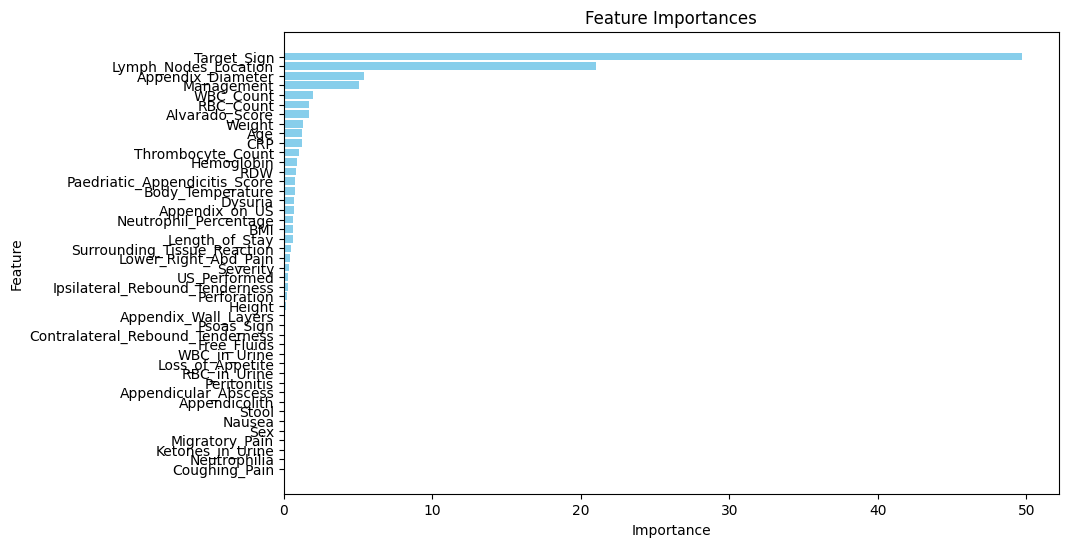

In [ ]:
# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Логистическая регрессия

In [ ]:
lg_model = LogisticRegression(random_state=42, max_iter=10000)


In [ ]:
lg_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [ ]:
y_pred = lg_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        91
           1       1.00      0.94      0.97        65

    accuracy                           0.97       156
   macro avg       0.98      0.97      0.97       156
weighted avg       0.98      0.97      0.97       156



# PyTorch (SimpleNN)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [ ]:
# Создание PyTorch датасетов
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
# Создание PyTorch загрузчиков данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
model = SimpleNN(input_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epochs = 20
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Сохраняем среднее значение потерь за эпоху
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

print('Training finished')

Epoch 1, Loss: 3.913482689857483
Epoch 2, Loss: 0.6773426115512848
Epoch 3, Loss: 0.6749483287334442
Epoch 4, Loss: 0.6758415281772614
Epoch 5, Loss: 0.6745336532592774
Epoch 6, Loss: 0.6735183775424958
Epoch 7, Loss: 0.6755473256111145
Epoch 8, Loss: 0.6744909346103668
Epoch 9, Loss: 0.6747366428375244
Epoch 10, Loss: 0.6740854263305665
Epoch 11, Loss: 0.673499059677124
Epoch 12, Loss: 0.6750082790851593
Epoch 13, Loss: 0.6739032566547394
Epoch 14, Loss: 0.6744933307170868
Epoch 15, Loss: 0.6748766958713531
Epoch 16, Loss: 0.675242441892624
Epoch 17, Loss: 0.6746844589710236
Epoch 18, Loss: 0.6749384880065918
Epoch 19, Loss: 0.6747532784938812
Epoch 20, Loss: 0.6748712599277497
Training finished


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test data: {100 * correct / total}%')

Accuracy on the test data: 58.333333333333336%


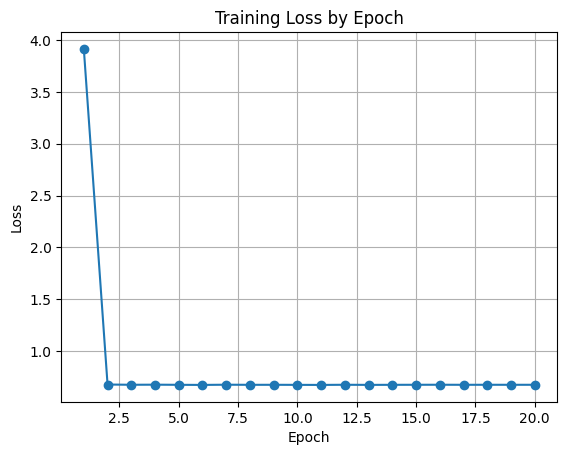

In [ ]:
# Построение графика ошибки по эпохам
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# PyTorch (TabularNN)

In [ ]:
import torch.nn.functional as F

In [ ]:
class TabularNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], output_size=2):
        super(TabularNN, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Входной слой
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Скрытые слои
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        # Выходной слой
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Применяем ReLU ко всем скрытым слоям
        for layer in self.hidden_layers:
            x = F.relu(layer(x))

        # Выходной слой
        x = self.output_layer(x)
        return x

In [ ]:
# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
# Создание PyTorch датасетов
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
# Создание PyTorch загрузчиков данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
input_size = X_train.shape[1]
model = TabularNN(input_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
epochs = 20
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Сохраняем среднее значение потерь за эпоху
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

print('Training finished')

Epoch 1, Loss: 2.7294256687164307
Epoch 2, Loss: 0.6582761287689209
Epoch 3, Loss: 0.6407657593488694
Epoch 4, Loss: 0.6647268831729889
Epoch 5, Loss: 0.6025961697101593
Epoch 6, Loss: 0.6856468051671982
Epoch 7, Loss: 0.6486749887466431
Epoch 8, Loss: 0.6708409011363983
Epoch 9, Loss: 0.6594069182872773
Epoch 10, Loss: 0.6539101302623749
Epoch 11, Loss: 0.6506945133209229
Epoch 12, Loss: 0.6339260816574097
Epoch 13, Loss: 0.614831805229187
Epoch 14, Loss: 0.6656072258949279
Epoch 15, Loss: 0.6579149246215821
Epoch 16, Loss: 0.6552719414234162
Epoch 17, Loss: 0.620060670375824
Epoch 18, Loss: 0.6075537264347076
Epoch 19, Loss: 0.5797681301832199
Epoch 20, Loss: 0.5857554316520691
Training finished


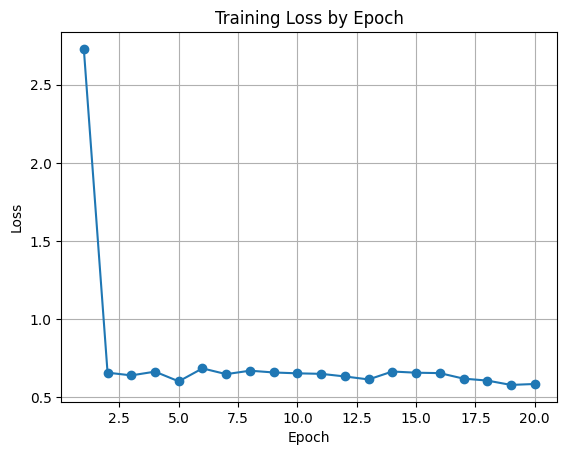

In [ ]:
# Построение графика ошибки по эпохам
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Вывод:

Лучшая модель по метрикам - CatBoost, но показатель единица очень настараживает. Логистическая регрессия показала себя чуть хуже. Но метрики высокие.

Нейронные сетки PyTorch SimpleNN и TabularNN показали себя плохо. Функции потерь высокие: TabularNN (0.58),  SimpleNN (0.67)